In [2]:
from pathlib import Path
from typing import Union, Optional
import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import axes
import xarray as xr
import pandas as pd
from spotpy.algorithms import _algorithm
import spotpy
import tqdm
from scipy.stats import wasserstein_distance
import dask.array as da

## Define Multidimensional Objective Functions

In [3]:
obj_func_direction = {
    'mse': 'minimize',
    'rmse': 'minimize',
    'nrmse': 'minimize',
    'nse': 'maximize',
    'pbias': 'minimize'
}

def mse_md(observation: np.ndarray, simulation: np.ndarray, return_dict: bool = False, axis=0):
    if observation.shape[axis] == simulation.shape[axis]:
        mse = np.nanmean((observation - simulation) ** 2, axis=axis)
        if return_dict:
            return {'mse': mse}
        else:
            return mse
    else:
        raise ValueError("evaluation and simulation data do not have the same length.")


def rmse_md(observation: np.ndarray, simulation: np.ndarray, return_dict: bool = False, axis=0):
    if observation.shape[axis] == simulation.shape[axis]:
        mse = mse_md(observation, simulation, axis=axis)
        rmse = np.sqrt(mse)
        if return_dict:
            return {'rmse': rmse}
        else:
            return rmse
    else:
        raise ValueError("evaluation and simulation data do not have the same length.")


def nrmse_md(observation: np.ndarray, simulation: np.ndarray, return_dict: bool = False, axis=0):
    if observation.shape[axis] == simulation.shape[axis]:
        nrmse = rmse_md(observation, simulation, axis=axis) / np.nanmean(observation, axis=axis)
        if return_dict:
            return {'nrmse': nrmse}
        else:
            return nrmse
    else:
        raise ValueError("evaluation and simulation data do not have the same length.")


def nse_md(observation: np.ndarray, simulation: np.ndarray, return_dict: bool = False, axis=0):
    if observation.shape[axis] == simulation.shape[axis]:
        mean_observed = np.nanmean(observation, axis=axis)
        # compute numerator and denominator
        numerator = np.nansum((observation - simulation) ** 2, axis=axis)
        denominator = np.nansum((observation - mean_observed) ** 2, axis=axis)
        # compute coefficient
        nse = 1 - (numerator / denominator)
        if return_dict:
            return {'nse': nse}
        else:
            return nse
    else:
        raise ValueError("evaluation and simulation data do not have the same length.")


def pbias_md(observation: np.ndarray, simulation: np.ndarray, return_dict: bool = False, axis=0):
    if observation.shape[axis] == simulation.shape[axis]:
        pbias = np.nansum(simulation - observation, axis=axis) / np.nansum(observation, axis=axis)
        if return_dict:
            return {'pbias': pbias}
        else:
            return pbias
    else:
        raise ValueError("evaluation and simulation data do not have the same length.")


## Classes for MSC-UA Calibration

In [4]:
# Base class for a multidimensional database for the calibration. This could be used in future expansion to other formats
class MultiDimDb:
    format = None
    def __init__(
            self,
            dbname: str,
            dbpath: Union[str, Path],
            dims: Optional[dict] = None,
            dim_names: Optional[dict] = None,
            dbappend: bool = False,
            save_sim: bool = False,
    ):
        
        self.dbname = dbname
        self.cwd = dbpath
        self.dims = dims
        self.dim_names = dim_names
        self.dbappend = dbappend
        self.save_sim = save_sim

        self.ppu_upper = None
        self.ppu_lower = None
        self.pfactor = None
        self.rfactor = None
        self.thresholds = None
        self.best_sim = None
        self.best_params = None
        self.best_objfun = None


class MscuaSetup:
    # Define parameters here (before __init__) as variables

    def __init__(self, objective_funcs, type='run_interation', dbase: Optional[Union[str, Path, MultiDimDb]] = None):
        self.setup_type = type
        self.parameter_dimension = {}
        self.param_dim_names = {}
        self.indata = None
        self.observation_data = None
        if isinstance(objective_funcs, list):
            self.objfuncs = objective_funcs
        else:
            self.objfuncs = [objective_funcs]

    def parameters(self):
        pass
    
    def simulation(self):
        pass

    def evaluation(self):
        pass

    def objectivefunction(self, observation, simulation):
        pass


# accepts 2 types of setup classes, a MscuaSetup() object with attribute .setup_type = 'run_iteration' OR .setup_type = 'evaluate_iteration'
# Can use custom objective functions for filtering parameter sets but note that they must return a dictionary {'name_of_function': np.ndarray(values)}
class MsCua:
    
    algorithm_name = "MSCUA"
    
    def __init__(
            self,
            setup_class: MscuaSetup,
            dbname: str = 'mscuaDb',
            dbformat: str = 'memory',
            dbappend: bool = False,
            iter_db: Union[str, Path, None] = None

    ):
        self.setup = setup_class
        if dbformat == 'memory':
            self.database = MemDb(dbname=dbname)
        else:
            raise NotImplementedError("Other databases not supported yet, choose 'memory'")
        
        self.observation_data = self.setup.evaluation()

    def evaluate_iteration(self, dbase: MultiDimDb, objfunc_thresh: dict, min_pfactor: float = 0.35, min_refparams: int = 25):
        """
        Example objfunc_thresh dict:
        {'nse': 0.5, 'nrmse': 0.1}
            
        """
        if dbase.format == 'memory':
            if not dbase.parameter_samples:
                raise AttributeError("No paramter samples have been saved to the input database.")
            if len(dbase.simulation_results) == 0:
                raise AttributeError("No simulation data has been saved to the input database.")
            
            dbase.thresholds = objfunc_thresh
            dbase.thresholds.update({"pfactor_threshold": min_pfactor})
            dbase.thresholds.update({"min_refined_params_threshold": min_refparams})
            dbase._ref_par = copy.deepcopy(dbase._par_samples)
            reps = len(dbase.simulation_results)
            print("Evaluating Objective Function Values...")
            # need to convert simulation_results into an array here...sooner than it was
            sims_arr = np.array(dbase.simulation_results)
            ob = self.setup.objectivefunction(self.observation_data[None,:,:], sims_arr)
            if not isinstance(ob, dict):
                raise ValueError("The setup class's objective function method did not return a dictionary. A dictionary of objective functions is required.")
            dbase.save(objective_func=ob)
            best_sim = {}
            best_obfn = {}
            best_params = {}
            for k,v in ob.items():
                if obj_func_direction[k] == 'minimize':
                    best_rep = sims_arr[v.argmin(axis=0),:,np.arange(v.shape[1])].T
                    best_ob = v[v.argmin(axis=0),np.arange(v.shape[1])]
                    best_par = {}
                    for pk,pv in dbase.refined_parameters.items():
                        best_par.update({pk: pv[v.argmin(axis=0), np.arange(v.shape[1])]})
                elif obj_func_direction[k] == 'maximize':
                    best_rep = sims_arr[v.argmax(axis=0),:,np.arange(v.shape[1])].T
                    best_ob = v[v.argmax(axis=0),np.arange(v.shape[1])]
                    best_par = {}
                    for pk,pv in dbase.refined_parameters.items():
                        best_par.update({pk: pv[v.argmax(axis=0), np.arange(v.shape[1])]})
                else:
                    raise ValueError("The objective function threshold direction is not recognized.")
                best_sim.update({k: best_rep})
                best_obfn.update({k: best_ob})
                best_params.update({k: best_par})
            dbase.best_sim = best_sim
            dbase.best_params = best_params
            dbase.best_objfun = best_obfn
            fil = {}
            for k,v in ob.items():
                if k not in list(objfunc_thresh.keys()):
                    raise ValueError(f"No threshold was provided for objective function {k}.")
                if obj_func_direction[k] == 'minimize':
                    filter = np.where(v > objfunc_thresh[k])
                elif obj_func_direction[k] == 'maximize':
                    filter = np.where(v < objfunc_thresh[k])
                else:
                    raise ValueError("The objective function threshold direction is not recognized.")
                fil[k] = filter
                for park in dbase.refined_parameters.keys():
                    for k, v in fil.items():
                        dbase._ref_par[park][v] = np.nan
            param_nans = np.isnan(dbase.refined_parameters[list(dbase.refined_parameters.keys())[0]])
            refined_param_cnt = np.count_nonzero(~param_nans, axis=0)
            print(f"Max number of refined parameter sets: {refined_param_cnt.max()}")
            print(f"Min number of refined parameter sets: {refined_param_cnt.min()}")
            ref_less_than = np.count_nonzero(refined_param_cnt < min_refparams)
            # Remove simulations from sim_arr that did not meet objective function thresholds
            ref_sims_idx = np.where(param_nans)
            sims_arr[ref_sims_idx[0],:,ref_sims_idx[1]] = np.nan
            ## calculate 95PPU here
            print("Calculating the 95PPU...")
            obs_sd = np.std(self.observation_data, axis=0)
            up95ppu = np.nanquantile(sims_arr, 0.975, axis=0)
            lo95ppu = np.nanquantile(sims_arr, 0.025, axis=0)
            print("Calculating p- and r-factor metrics...")
            pfac_arr = np.where((self.observation_data <= up95ppu) & (self.observation_data >= lo95ppu), 1, 0)
            pfac_cnt = np.count_nonzero(pfac_arr, axis=0)
            pfactor = pfac_cnt / up95ppu.shape[0]
            ppu_diff = (up95ppu - lo95ppu).mean(axis=0)
            rfactor = ppu_diff / obs_sd
            print(f"Max p-factor = {pfactor.max()}")
            print(f"Min p-factor = {pfactor.min()}")
            print(f"Min r-factor = {np.nanmin(rfactor)}")
            print(f"Max r-factor = {np.nanmax(rfactor)}")
            dbase.ppu_upper = up95ppu
            dbase.ppu_lower = lo95ppu
            dbase.pfactor = pfactor
            dbase.rfactor = rfactor

            if ref_less_than == 0:
                print(f"All models retained more refined parameter sets than the minimun: {min_refparams}.")
                if np.count_nonzero(pfactor < min_pfactor) == 0:
                    print(f"All models had p-factor greater than {min_pfactor}")
                else:
                    print(f"{np.count_nonzero(pfactor < min_pfactor)} models had a p-factor lower than the allowable minimum: {min_pfactor}. Returning array of failed indexes.")
                    return np.where(pfactor < min_pfactor)[0]
            else:
                print(f"{ref_less_than} models had fewer than the minimum allowable refined parameter sets: {min_refparams}. Either increase the number of samples or exclude these models.")
                print(f"Returning array of failed model indexes.")
                if np.count_nonzero(pfactor < min_pfactor) == 0:
                    print(f"All models had p-factor greater than {min_pfactor}")
                    return np.where(refined_param_cnt < min_refparams)[0]
                else:
                    print(f"{np.count_nonzero(pfactor < min_pfactor)} models had a p-factor lower than the allowable minimum: {min_pfactor}. Returning array of failed indexes.")
                    return np.where(pfactor < min_pfactor)[0], np.where(refined_param_cnt < min_refparams)[0]        

        else:
            raise NotImplementedError("Other databases not supported")

    def sample(self, reps: int, objfunc_thresholds: dict, min_pfactor: float = 0.35, min_refparams: int = 25, **kwargs):
        plist = build_parameter_list(self.setup, self.setup.parameter_dimension, self.setup.param_dim_names)
        samples, newdb = LHS_md(plist, repetitions=reps, dbase=self.database, **kwargs)
        self.database = newdb
        run_multidim_model_reps(self.setup, self.database)
        iter_result = self.evaluate_iteration(self.database, objfunc_thresholds, min_pfactor, min_refparams)
        if iter_result is None:
            return None
        else:
            return iter_result

    def _evaluate_rep(self, obs_data: np.ndarray, rep_simulations: np.ndarray, objfunc_thresh: dict):
        ob = self.setup.objectivefunction(obs_data, rep_simulations)
        if not isinstance(ob, dict):
            raise ValueError("The setup class's objective function method did not return a dictionary. A dictionary of objective functions is required.")
        fil = {}
        for k,v in ob.items():
            if k not in list(objfunc_thresh.keys()):
                raise ValueError(f"No threshold was provided for objective function {k}.")
            if obj_func_direction[k] == 'minimize':
                filter = np.where(v > objfunc_thresh[k])
            elif obj_func_direction[k] == 'maximize':
                filter = np.where(v < objfunc_thresh[k])
            else:
                raise ValueError("The objective function threshold direction is not recognized.")
            
            fil[k] = filter
        
        return ob, fil


class MsCuaAnalyzer:

    def __init__(self, dbase: Union[MultiDimDb, xr.Dataset]):
        
        if isinstance(dbase, MultiDimDb):
            self.dbase = dbase
            if self.dbase.format == 'memory':
                self.ds = self.dbase.to_xarray()
            else:
                self.ds = self.dbase
        else:
            self.dbase = None
            self.ds = dbase

    def plot_pfactor(self, threshold: bool = False):
        ax = plt.axes()
        ax.hist(self.ds.pfactor.values)
        if threshold:
            ax.axvline(self.ds.pfactor_threshold.values, color='black', ls='--', label='Threshold')
            ax.legend()
        ax.set_ylabel("Frequency", fontsize=12)
        ax.set_xlabel("pfactor Value", fontsize=12)
        plt.show()
    
    def plot_rfactor(self):
        ax = plt.axes()
        ax.hist(self.ds.rfactor.values)
        ax.set_ylabel("Frequency", fontsize=12)
        ax.set_xlabel("rfactor Value", fontsize=12)
        plt.show()
    
    def plot_refined_parameters(self, param: str, indx: int = 0, ax: Optional[axes.Axes] = None, **kwargs):
        if ax is None:
            ax = plt.axes()
        else:
            ax = ax
        ax.hist(self.ds[f"{param}_refined"].values[:,indx])
        ax.set_ylabel("Frequency", fontsize=12)
        ax.set_xlabel(f"Refined {param} Value", fontsize=12)
        plt.show()
    
    def compare_parameter_distributions(self, param: str, comp_dstb: Union[np.ndarray, list], indx: int = 0, ax: Optional[axes.Axes] = None, **kwargs):
        dims = self.ds[f"{param}_samples"].dims
        if ax is None:
            ax = plt.axes()
        else:
            ax = ax
        ax.hist(comp_dstb, label='comparison parameter values', **kwargs)
        ax.hist(self.ds[f"{param}_refined"].values[:,indx], label='refined parameter values', **kwargs)
        ax.set_ylabel("Frequency", fontsize=12)
        ax.set_xlabel(f"{param} Value", fontsize=12)
        ax.set_title(f"{dims[1]}: {indx}", fontsize=12)
        ax.legend()
        plt.show()
    
    def plot_ppu(self, indx: int = 0, best_sim: bool = False, obs_data: Optional[np.ndarray] = None, sort: bool = False, ax: Optional[axes.Axes] = None):
        dims = self.ds["95PPU_lower"].dims
        if ax is None:
            ax = plt.axes()
        else:
            ax = ax
        if sort:
            srt_idx = np.argsort(self.ds["95PPU_lower"].values[:,indx])
            ax.fill_between(np.arange(self.ds["95PPU_lower"].values.shape[0]), 
                            self.ds["95PPU_upper"].values[srt_idx,indx], 
                            self.ds["95PPU_lower"].values[srt_idx,indx], 
                            label="95 Percentile Prediction Uncertainty",
                            ec='blue',
                            alpha=0.3)
            if obs_data is not None:
                if self.ds["95PPU_lower"].values.shape != obs_data.shape:
                    raise ValueError("The input observation data does not match the size of the modeled 95 percent prediction uncertainty.")
                ax.plot(np.sort(obs_data[:,indx]), marker=None, ls='-', lw=1.2, color='black', label='Observed Values')
            if best_sim:
                for i in self.ds["objective_functions"].values:
                    ax.plot(self.ds[f"best_simulation_{i}"].values[srt_idx, indx], marker=None, ls='--', lw=1, color='red', label=f'Best Model Simulation - {i}')
        else:
            ax.fill_between(np.arange(self.ds["95PPU_lower"].values.shape[0]), 
                            self.ds["95PPU_upper"].values[:,indx], 
                            self.ds["95PPU_lower"].values[:,indx], 
                            label="95 Percentile Prediction Uncertainty")
            if obs_data is not None:
                if self.ds["95PPU_lower"].values.shape != obs_data.shape:
                    raise ValueError("The input observation data does not match the size of the modeled 95 percent prediction uncertainty.")
                ax.plot(obs_data[:,indx], markers=None, ls='-', lw=1.25, color='black', label='Observed Values')
            if best_sim:
                for i in self.ds["objective_functions"].values:
                    ax.plot(self.ds[f"best_simulation_{i}"].values[:, indx], marker=None, ls='--', lw=1, color='red', label=f'Best Model Simulation - {i}')
        ax.set_ylabel("Model Output Values", fontsize=12)
        ax.set_xlabel(dims[0], fontsize=12)
        ax.set_title(f"{dims[1]}: {indx}", fontsize=12)
        ax.legend()
        plt.show()

    def plot_objective_functions(self, indx: int = 0, threshold: bool = False):
        n = len(self.ds.objective_functions)
        if n % 2 == 0:
            fig, axs = plt.subplots(int(n/2), 2, sharex=True)
        else:
            fig, axs = plt.subplots(int(n/2+1), 2, sharex=True)
        for i, v in enumerate(self.ds.objective_functions.values.tolist()):
            if i % 2 == 0:
                if len(axs.shape) > 1:
                    ax_i = axs[int(i/2), 0]
                else:
                    ax_i = axs[0]
                ax_i.hist(self.ds[v].values[:, indx])
                if threshold:
                    thresh = self.ds.obj_func_thresholds.sel(objective_functions=v).values
                    ax_i.axvline(thresh, color='black', ls='--', label='Threshold')
                    ax_i.legend()
                ax_i.set_title(f"{self.ds[v].dims[1]} {indx}: {v}")
            else:
                if len(axs.shape) > 1:
                    ax_i = axs[int(i/2), 1]
                else:
                    ax_i = axs[1]
                ax_i.hist(self.ds[v].values[:, indx])
                if threshold:
                    thresh = self.ds.obj_func_thresholds.sel(objective_functions=v).values
                    ax_i.axvline(thresh, color='black', ls='--', label='Threshold')
                    ax_i.legend()
                ax_i.set_title(f"{self.ds[v].dims[1]} {indx}: {v}")
        if n % 2 != 0:
            if len(axs.shape) > 1:
                for l in axs[int(n/2)-1,1].get_xaxis().get_majorticklabels():
                    l.set_visible(True)
                fig.delaxes(axs[int(n/2), 1])
                for ax in axs[-1, :]:
                    ax.set_xlabel('Objective Function Value')
                for ax in axs[:, 0]:
                    ax.set_ylabel('Frequency')
            else:
                for l in axs[1].get_xaxis().get_majorticklabels():
                    l.set_visible(True)
                fig.delaxes(axs[1])
                for ax in axs:
                    ax.set_xlabel('Objective Function Value')
                axs[0].set_ylabel('Frequency')
        plt.tight_layout()
        plt.show()

    def plot_best_objfuncs(self, threshold: bool = False):
        n = len(self.ds.objective_functions)
        if n % 2 == 0:
            fig, axs = plt.subplots(int(n/2), 2, sharex=True)
        else:
            fig, axs = plt.subplots(int(n/2+1), 2, sharex=True)
        for i, v in enumerate(self.ds.objective_functions.values.tolist()):
            if i % 2 == 0:
                if len(axs.shape) > 1:
                    ax_i = axs[int(i/2), 0]
                else:
                    ax_i = axs[0]
                ax_i.hist(self.ds.best_obj_function.sel(objective_functions=v).values)
                if threshold:
                    thresh = self.ds.obj_func_thresholds.sel(objective_functions=v).values
                    ax_i.axvline(thresh, color='black', ls='--', label='Threshold')
                    ax_i.legend()
                ax_i.set_title(f"Best {v} value per {self.ds[v].dims[1]}")
            else:
                if len(axs.shape) > 1:
                    ax_i = axs[int(i/2), 1]
                else:
                    ax_i = axs[1]
                ax_i.hist(self.ds.best_obj_function.sel(objective_functions=v).values)
                if threshold:
                    thresh = self.ds.obj_func_thresholds.sel(objective_functions=v).values
                    ax_i.axvline(thresh, color='black', ls='--', label='Threshold')
                    ax_i.legend()
                ax_i.set_title(f"Best {v} value per {self.ds[v].dims[1]}")
        if n % 2 != 0:
            if len(axs.shape) > 1:
                for l in axs[int(n/2)-1,1].get_xaxis().get_majorticklabels():
                    l.set_visible(True)
                fig.delaxes(axs[int(n/2), 1])
                for ax in axs[-1, :]:
                    ax.set_xlabel('Objective Function Value')
                for ax in axs[:, 0]:
                    ax.set_ylabel('Frequency')
            else:
                for l in axs[1].get_xaxis().get_majorticklabels():
                    l.set_visible(True)
                fig.delaxes(axs[1])
                for ax in axs:
                    ax.set_xlabel('Objective Function Value')
                axs[0].set_ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    
    def plot_number_refined_params(self, threshold: bool = False):
        arb_parm = self.ds.parameters.values[0]
        nans = np.isnan(self.ds[f"{arb_parm}_refined"].values)
        nz = np.count_nonzero(~nans, axis=0)
        ax = plt.axes()
        ax.hist(nz)
        if threshold:
            ax.axvline(self.ds.min_refined_params_threshold.values, color='black', ls='--', label='Threshold')
            ax.legend()
        ax.set_ylabel("Frequency", fontsize=12)
        ax.set_xlabel("Number Refined Parameter Sets", fontsize=12)
        plt.show()
    
    def calc_param_distribution_change(self, param: str, comp_dstb: Union[np.ndarray, list], indx: int = 0):
        d1 = comp_dstb
        d2 = self.ds[f"{param}_refined"].values[:,indx]
        ws_dist = wasserstein_distance(d1[~np.isnan(d1)], d2[~np.isnan(d2)])

        return ws_dist


class SensitivityAnalysis:

    def __init__(self,
                 setup_class: MscuaSetup,
                 ):
        
        self.setup = setup_class
                
        self.observation_data = self.setup.evaluation()
        self.results = None

    def sample(self, reps: int = 10):
        plist = build_parameter_list(self.setup, self.setup.parameter_dimension, self.setup.param_dim_names)
        pnames = []
        objf_names = None
        init_samp = {}
        for p in plist:
            name = p.name
            pnames.append(name)
            sv = np.repeat(p(), p.dim)
            init_samp.update({name: sv})
        rslt = xr.Dataset()
        rslt.coords['parameters'] = (('parameters',), pnames)
        rslt.coords['repetitions'] = (('repetitions',), np.arange(reps)+1)
        rslt.coords[plist[0].dim_name] = ((plist[0].dim_name,), np.arange(plist[0].dim)+1)
        arr_sz = (len(pnames), reps, self.setup.parameter_dimension[pnames[0]])
        active_samp = copy.deepcopy(init_samp)
        segment = 1 / float(reps)
        rslt['samples'] = (('parameters', 'repetitions', plist[0].dim_name), da.from_array(np.empty(arr_sz), chunks='auto'))
        for i, p in enumerate(plist):
            # sample parameter space here
            parmin = p.minbound
            parmax = p.maxbound
            
            if isinstance(parmin, float):
                parmin = np.repeat(parmin, p.dim)
            if isinstance(parmax, float):
                parmax = np.repeat(parmax, p.dim)
                
            print(f"Sampling {reps} repetitions of the {p.name} parameter...")
            for r in tqdm.tqdm(range(reps), desc=f"{p.name} samples", leave=False):
                # iterate samples per paramter here, run simulation, calculate objective function and assign values
                segmentMin = r * segment
                pointInSegment = segmentMin + (np.random.random() * segment)
                parset = pointInSegment * (parmax - parmin) + parmin
                active_samp[p.name] = parset
                rslt['samples'].values[i, r, :] = parset
                sim = self.setup.simulation(active_samp)
                ob = self.setup.objectivefunction(self.observation_data, sim)
                if objf_names is None:
                    objf_names = []
                    for k in ob.keys():
                        objf_names.append(k)
                    rslt.coords['objective_functions'] = (('objective_functions',), objf_names)
                # logic to check for obj func name in dataset datavars, if not there, add (initialize dask empty dask array), if it is there append by index
                for k,v in ob.items():
                    if k not in list(rslt.data_vars):
                        rslt[k] = (('parameters', 'repetitions', p.dim_name), da.from_array(np.empty(arr_sz), chunks='auto'))
                        rslt[k].values[i,r,:] = v
                    else:
                        rslt[k].values[i,r,:] = v
            # result active samp
            active_samp[p.name] = init_samp[p.name]
        
        sens_indx = da.from_array(np.empty((len(rslt['objective_functions'].values), arr_sz[0], arr_sz[2])), chunks='auto')
        for i, obf in enumerate(rslt['objective_functions'].values.tolist()):
            d = np.nanmax(rslt[obf].values, axis=(0,1)) - np.nanmin(rslt[obf].values, axis=(0,1))
            for j, par in enumerate(rslt['parameters'].values.tolist()):
                n = np.nanmax(rslt[obf].sel(parameters=par).values, axis=0) - np.nanmin(rslt[obf].sel(parameters=par).values, axis=0)
                sens_arr = n / d
                sens_indx[i, j, :] = sens_arr
        rslt['sensitivity_index'] = (('objective_functions', 'parameters', plist[0].dim_name), sens_indx)
        self.results = rslt

    def plot_sensitivity_index(self, indx: int = 0):
        if self.results is None:
            raise AttributeError("The sensitivity analysis has not been run yet, the results are empty.")
        
        n = len(self.results.objective_functions)
        if n % 2 == 0:
            fig, axs = plt.subplots(int(n/2), 2)
        else:
            fig, axs = plt.subplots(int(n/2+1), 2)
        for i, v in enumerate(self.results.objective_functions.values.tolist()):
            if i % 2 == 0:
                if len(axs.shape) > 1:
                    ax_i = axs[int(i/2), 0]
                else:
                    ax_i = axs[0]
                ax_i.bar(self.results.parameters.values, self.results['sensitivity_index'].sel(objective_functions=v).values[:,indx])
                ax_i.set_title(f"{v}: {self.results['sensitivity_index'].dims[2]} {indx}")
            else:
                if len(axs.shape) > 1:
                    ax_i = axs[int(i/2), 1]
                else:
                    ax_i = axs[1]
                ax_i.bar(self.results.parameters.values, self.results['sensitivity_index'].sel(objective_functions=v).values[:,indx])
                ax_i.set_title(f"{v}: {self.results['sensitivity_index'].dims[2]} {indx}")
        if n % 2 != 0:
            if len(axs.shape) > 1:
                for l in axs[int(n/2)-1,1].get_xaxis().get_majorticklabels():
                    l.set_visible(True)
                fig.delaxes(axs[int(n/2), 1])
                for ax in axs[:, 0]:
                    ax.set_ylabel('Sensitivity Index')
            else:
                for l in axs[1].get_xaxis().get_majorticklabels():
                    l.set_visible(True)
                fig.delaxes(axs[1])
                axs[0].set_ylabel('Sensitivity Index')
        plt.tight_layout()
        plt.show()

    def plot_sensitivity_distribution(self, param: str):
        if self.results is None:
            raise AttributeError("The sensitivity analysis has not been run yet, the results are empty.")
        
        n = len(self.results.objective_functions)
        if n % 2 == 0:
            fig, axs = plt.subplots(int(n/2), 2)
        else:
            fig, axs = plt.subplots(int(n/2+1), 2)
        for i, v in enumerate(self.results.objective_functions.values.tolist()):
            if i % 2 == 0:
                if len(axs.shape) > 1:
                    ax_i = axs[int(i/2), 0]
                else:
                    ax_i = axs[0]
                ax_i.hist(self.results['sensitivity_index'].sel(objective_functions=v, parameters=param).values)
                ax_i.set_xlabel(f"{param} Sensitivity Indexes")
                ax_i.set_ylabel("Frequency")
                ax_i.set_title(f"{v}")
            else:
                if len(axs.shape) > 1:
                    ax_i = axs[int(i/2), 1]
                else:
                    ax_i = axs[1]
                ax_i.hist(self.results['sensitivity_index'].sel(objective_functions=v, parameters=param).values)
                ax_i.set_xlabel(f"{param} Sensitivity Indexes")
                ax_i.set_ylabel("Frequency")
                ax_i.set_title(f"{v}")
        if n % 2 != 0:
            if len(axs.shape) > 1:
                for l in axs[int(n/2)-1,1].get_xaxis().get_majorticklabels():
                    l.set_visible(True)
                fig.delaxes(axs[int(n/2), 1])
            else:
                for l in axs[1].get_xaxis().get_majorticklabels():
                    l.set_visible(True)
                fig.delaxes(axs[1])
        plt.tight_layout()
        plt.show()
    
    def plot_obj_func(self, obj_func: str, indx: int = 0):
        if self.results is None:
            raise AttributeError("The sensitivity analysis has not been run yet, the results are empty.")
        
        n = len(self.results.parameters)
        if n % 2 == 0:
            fig, axs = plt.subplots(int(n/2), 2)
        else:
            fig, axs = plt.subplots(int(n/2+1), 2)
        for i, v in enumerate(self.results.parameters.values.tolist()):
            if i % 2 == 0:
                if len(axs.shape) > 1:
                    ax_i = axs[int(i/2), 0]
                else:
                    ax_i = axs[0]
                ax_i.plot(self.results['samples'].sel(parameters=v).values[:,indx], self.results[obj_func].sel(parameters=v).values[:,indx])
                ax_i.set_xlabel(f"{v} Value")
                ax_i.set_ylabel(obj_func)
            else:
                if len(axs.shape) > 1:
                    ax_i = axs[int(i/2), 1]
                else:
                    ax_i = axs[1]
                ax_i.plot(self.results['samples'].sel(parameters=v).values[:,indx], self.results[obj_func].sel(parameters=v).values[:,indx])
                ax_i.set_xlabel(f"{v} Value")
                ax_i.set_ylabel(obj_func)
        if n % 2 != 0:
            if len(axs.shape) > 1:
                for l in axs[int(n/2)-1,1].get_xaxis().get_majorticklabels():
                    l.set_visible(True)
                fig.delaxes(axs[int(n/2), 1])
            else:
                for l in axs[1].get_xaxis().get_majorticklabels():
                    l.set_visible(True)
                fig.delaxes(axs[1])
        plt.tight_layout()
        plt.show()
    

# A child class of MultiDimDb that creates a set of zarr files to database calibration output
class ZarrDb(MultiDimDb):
    format = 'zarr'
    def __init__(self, *args, chunks: Optional[dict] = None, **kwargs):
        
        super(ZarrDb, self).__init__(*args, **kwargs)
        self.chunks = chunks
    
    def save(self):
        pass

    @staticmethod
    def load(dbpth: Union[str, Path]):
        pass


# create a netcdf with dummy data and then write to each region to fill it out...use chunks for dask capabilities?
class NetcdfDb(MultiDimDb):
    format = 'netcdf'
    def __init__(self, *args, chunks: Optional[dict] = None, **kwargs):
        
        super(NetcdfDb, self).__init__(*args, **kwargs)
        self.chunks = chunks
    
    def save(self):
        pass

    @staticmethod
    def load(dbpth: Union[str, Path]):
        pass


class MemDb(MultiDimDb):
    format = 'memory'

    def __init__(self, *args, **kwargs):
        
        super(MemDb, self).__init__(*args, dbpath=None, **kwargs)
        print("In Memory database initialized...")
        self._par_samples = {}
        self._ref_par = {}
        self._objfun = {}
        self._sim = []
        self._obs_index = None
    
    @property
    def simulation_results(self):
        return np.array(self._sim)
    
    @property
    def parameter_samples(self):
        return self._par_samples
    
    @property
    def refined_parameters(self):
        return self._ref_par

    @property
    def objective_func_values(self):
        return self._objfun

    @property
    def observation_labels(self):
        return self._obs_index
    
    @observation_labels.setter
    def observation_labels(self, new_in: np.ndarray):
        if self.simulation_results is None:
            raise AttributeError("No simulation results, save simulations first before assigning observation labels.")
        if new_in.size != self.simulation_results[0].shape[1]:
            raise ValueError("The input array is not the same length as observations dimension.")
        self._obs_index = new_in

    def save(self, param_dict: Optional[dict] = None, objective_func: Optional[dict] = None, simulations: Optional[np.ndarray] = None):
        if (param_dict is None) & (objective_func is None) & (simulations is None):
            print("No data to save")
        else:
            if param_dict is not None:
                if not self._par_samples:
                    self._par_samples.update(param_dict)
                else:
                    for k,v in param_dict.items():
                        self._par_samples[k] = np.vstack((self._par_samples[k], v))
            
            if objective_func is not None:
                if not self._objfun:
                    self._objfun.update(objective_func)
                else:
                    for k,v in objective_func.items():
                        self._objfun[k] = np.vstack((self._objfun[k], v))
            
            if simulations is not None:
                self._sim.append(simulations)

    def to_xarray(self):
        ds = xr.Dataset()
        param_names = []
        for k in list(self._par_samples.keys()):
            param_names.append(k)
        objfunc_names = []
        for k in list(self.objective_func_values):
            objfunc_names.append(k)
        if self.parameter_samples is not None:
            for pnm in param_names:
                ds[f"{pnm}_samples"] = (("repetition", self.dim_names[pnm]), self.parameter_samples[pnm], {"description": "original parameter sample"})
        if self.refined_parameters is not None:
            for pnm in param_names:
                ds[f"{pnm}_refined"] = (("repetition", self.dim_names[pnm]), self.refined_parameters[pnm], {"description": "refined parameter set"})
        if self.objective_func_values is not None:
            for obf in objfunc_names:
                ds[obf] = (("repetition", self.dim_names[list(self.dim_names.keys())[0]]), self.objective_func_values[obf], {"description": "objective function"})
                if self.best_sim is not None:
                    ds[f"best_simulation_{obf}"] = (("observation", self.dim_names[list(self.dim_names.keys())[0]]), self.best_sim[obf], {"description": f"the simulation repitition with the best {obf} value"})
                
            if self.best_objfun is not None:
                bst_obfn = []
                bst_params = []
                for obf in objfunc_names:
                    bst_obfn.append(self.best_objfun[obf])
                    bst_p_mid = []
                    if self.best_params is not None:
                        for pnm in param_names:
                            bst_p_mid.append(self.best_params[obf][pnm])
                        bst_p_arr = np.array(bst_p_mid)
                        bst_params.append(bst_p_arr)
                ds["best_obj_function"] = (("objective_functions", self.dim_names[list(self.dim_names.keys())[0]]), np.array(bst_obfn))
                if self.best_params is not None:
                    ds["best_parameter_set"] = (("objective_functions", "parameters", self.dim_names[list(self.dim_names.keys())[0]]), np.array(bst_params))
        
        if len(self.simulation_results) != 0:
            ds["simulation_results"] = (("repetition", "observation", self.dim_names[list(self.dim_names.keys())[0]]), np.array(self._sim))
        if self.pfactor is not None:
            ds["pfactor"] = ((self.dim_names[list(self.dim_names.keys())[0]]), self.pfactor)
        if self.rfactor is not None:
            ds["rfactor"] = ((self.dim_names[list(self.dim_names.keys())[0]]), self.rfactor)
        if self.ppu_lower is not None:
            ds["95PPU_lower"] = (("observation", self.dim_names[list(self.dim_names.keys())[0]]), self.ppu_lower)
        if self.ppu_upper is not None:
            ds["95PPU_upper"] = (("observation", self.dim_names[list(self.dim_names.keys())[0]]), self.ppu_upper)

        coord_dict = {}
        for k,v in ds.dims.items():
            if k == 'objective_functions':
                coord_dict[k] = (k, objfunc_names)
            elif k == 'parameters':
                coord_dict[k] = (k, param_names)
            else:
                coord_dict[k] = (k, np.arange(v)+1)
            
        ds = ds.assign_coords(coord_dict)
        
        if self.thresholds is not None:
            obfthrs = np.empty(len(objfunc_names))
            for k,v in self.thresholds.items():
                if k == 'pfactor_threshold':
                    ds[k] = (('scalar',), np.array([v]))
                elif k == 'min_refined_params_threshold':
                    ds[k] = (('scalar',), np.array([v]))
                else:
                    if k in objfunc_names:
                        obidx = objfunc_names.index(k)
                        obfthrs[obidx] = v
            if not np.isinf(obfthrs).all():
                ds['obj_func_thresholds'] = (('objective_functions',), obfthrs)

        
        return ds


# TODO - This needs lots of improvements to generalize to iterative database writing (like for zarr)
# TODO - There also needs to be functionality for using an existing distribution's percentiles versus remaking the distribution based only on the bounds (traditional LHS)
def LHS_md(params: list[spotpy.parameter.Base], repetitions: int, dbase: MultiDimDb, use_distribution: bool = False):
    """

    Args:
        params:
        repetitions:
        dbase_name:
        dbase_format:

    """
    database = copy.deepcopy(dbase)
    param_dims = {}
    param_dim_names = {}
    for p in params:
        ndim = {p.name: p.dim}
        ndimname = {p.name: p.dim_name}
        param_dims.update(ndim)
        param_dim_names.update(ndimname)
    
    database.dims = param_dims
    database.dim_names = param_dim_names

    if use_distribution:
        Is = np.linspace(0, 1, repetitions + 1)
        Ie = np.roll(Is, -1)
        Is = Is[:-1].copy()
        Ie = Ie[:-1].copy()
        paramdict = {}
        for p in params:
            if p.rndfunctype == 'List':
                val_arr = p.values
                if len(val_arr.shape) != 2:
                    raise ValueError("For multidimensional LHS, a 2D paramter array is required for 'List' type.")
            else:
                vals = np.linspace(p.minbound, p.maxbound, repetitions)
                val_arr = np.repeat(vals[:,None], p.dim, axis=1)
            print(f"Sampling {repetitions} repetitions of the {p.name} parameter...")
            samples = []
            for i in tqdm.tqdm(range(len(Is)), desc=f'{p.name} samples', leave=False):
                rs_p = np.random.uniform(Is[i], Ie[i], p.dim)
                rs_v = np.nanquantile(val_arr, rs_p, axis=0)
                p_samps = rs_v[np.arange(p.dim), np.arange(p.dim)]
                samples.append(p_samps)

            paramdict.update({p.name: np.array(samples)})
    else:
        segment = 1 / float(repetitions)
        paramdict = {}
        for p in params:
            parmin = p.minbound
            parmax = p.maxbound
            
            if isinstance(parmin, float):
                parmin = np.repeat(parmin, p.dim)
            if isinstance(parmax, float):
                parmax = np.repeat(parmax, p.dim)
                
            matrix = np.empty((repetitions, p.dim))
            print(f"Sampling {repetitions} repetitions of the {p.name} parameter...")
            for i in tqdm.tqdm(range(repetitions), desc=f"{p.name} samples", leave=False):
                segmentMin = i * segment
                pointInSegment = segmentMin + (np.random.random() * segment)
                parset = pointInSegment * (parmax - parmin) + parmin
                matrix[i,:] = parset
            paramdict.update({p.name: matrix})
        
    # "Shuffle" or randomize the parameter sets (or combinations)
    for k,v in paramdict.items():
        np.random.shuffle(v)
        paramdict[k] = v
    
    database.save(param_dict=paramdict)
    
    if database.format == 'memory':
        if paramdict != database.parameter_samples:
            raise ValueError("The sampled parameter dictionary does not match the database parameter records...")
        else:
            paramdict = copy.deepcopy(database.parameter_samples)
        return paramdict, database
    else:    
        return paramdict


# function to build parameter list to be input into LHS function, include dimensions and dimension names as attributes of spotpy.parameter objects
def build_parameter_list(setup: MscuaSetup, parameter_dim: dict, parameter_dim_name: dict):
    
    cls = type(setup)
    class_vars = vars(cls).items()
    parameters = []
    for attrname, attrobj in class_vars:
        # Check if it is a spotpy parameter
        if isinstance(attrobj, spotpy.parameter.Base):
            if not attrobj.name:
                attrobj.name = attrname
            
            attrobj.dim = parameter_dim[attrobj.name]
            attrobj.dim_name = parameter_dim_name[attrobj.name]
            
            if attrobj.rndfunctype == 'List':
                if isinstance(attrobj.values, list):
                    attrobj.values = np.array(attrobj.values)
                if len(attrobj.values.shape) == 1:
                    if attrobj.values.shape[0] != parameter_dim[attrobj.name]:
                        raise ValueError("The provided parameter dimensions do not match the length of the List Parameter values.")
                    attrobj.maxbound = np.nanmax(attrobj.values)
                    attrobj.minbound = np.nanmin(attrobj.values)
                elif len(attrobj.values.shape) == 2:
                    if attrobj.values.shape[1] != parameter_dim[attrobj.name]:
                        raise ValueError("The provided parameter dimensions do not match the length of the List Parameter values.")
                    attrobj.maxbound = np.nanmax(attrobj.values, axis=0)
                    attrobj.minbound = np.nanmin(attrobj.values, axis=0)
                else:
                    raise NotImplementedError("List Parameter type with > 2 dimensions is not supported.")

            # Add parameter
            parameters.append(attrobj)

    return parameters


def query_parameters(params: Union[dict, MultiDimDb], rep_id: int):
    
    if rep_id == 0:
        raise IndexError("The rep_id argument is not zero based, for the first sample use rep_id=1")
    idx = rep_id - 1
    
    if isinstance(params, dict):
        q_par = {}
        for k,v in params.items():
            try:
                q = {k: v[idx,:]}
            except IndexError:
                print(f"rep_id = {rep_id}, there are only {v.shape[0]} parameters samples to query")
            q_par.update(q)
    elif isinstance(params, MultiDimDb):
        if params.format == 'memory':
            q_par = {}
            for k,v in params.parameter_records.items():
                try:
                    q = {k: v[idx,:]}
                except IndexError:
                    print(f"rep_id = {rep_id}, there are only {v.shape[0]} parameters samples to query")
                q_par.update(q)
        else:
            # need to query xarray dataset here and return a dict
            q_par = {}
    
    return q_par


def run_multidim_model_reps(setup: MscuaSetup, dbase: MultiDimDb):
    if dbase.format == 'memory':
        if not dbase.parameter_samples:
            raise AttributeError("No paramter samples have been saved to the input database.")
        
        itst = list(dbase.parameter_samples.keys())[0]
        reps = dbase.parameter_samples[itst].shape[0]
        print(f"Running model for {reps} repititions in database...")
        for i in tqdm.tqdm(np.arange(reps) + 1, desc='simulation', leave=False):
            qps = query_parameters(dbase.parameter_samples, i)
            mod = setup.simulation(qps)
            dbase.save(simulations=mod)


## Build a Dummy Model with Input Data & Observation Dataset

This is a simple Power-Law Function...it will serve as our model.

In [5]:
def exp_model(x, coef, exp):
    y = coef * x**(exp)
    return y

Create a set of random input values.

In [6]:
indata = np.random.uniform(1.0, 30.0, size=1000)

Run the model and add noise to the results to create our observation dataset.

In this case our target parameters are:
- coef = 0.03
- exp = 3.3

But for the actual calibration we will run the algorithm on 2000 power functions at once.

In [9]:
outdata = exp_model(indata, 0.03, 3.3)
inrng = outdata.max() - outdata.min()
noise = np.random.uniform(-inrng * 0.04, inrng * 0.04, size=outdata.shape)
obsdata = outdata + noise

Plot the observation data to inspect.

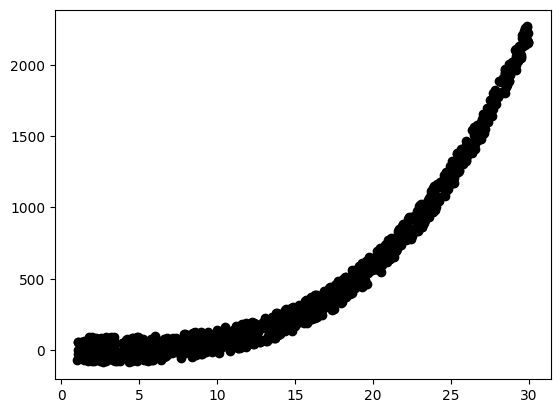

In [10]:
ax = plt.axes()
ax.plot(indata, obsdata, 'ko')

Ok, create the full multidimensional model and observation data.

In [8]:
target_coef = np.random.uniform(low=0.01, high=0.12, size=2000)
target_exp = np.random.uniform(low=1.1, high=3.9, size=2000)
mdindata = indata.reshape((indata.shape[0], 1))
outdata = exp_model(mdindata, target_coef, target_exp)
inrng = outdata.max(axis=0) - outdata.min(axis=0)
noise = np.random.uniform(-0.04, 0.04, size=(outdata.shape[0], 1))
mdnoise = noise * inrng
obsdata = outdata + mdnoise
obsdata = np.where(obsdata < 0, 0, obsdata)

Plot it to confirm that there are indeed 2000 "distinct" models in the array. Here we only plot two of the potential 2000 models but the shape of the array shows they are all there.

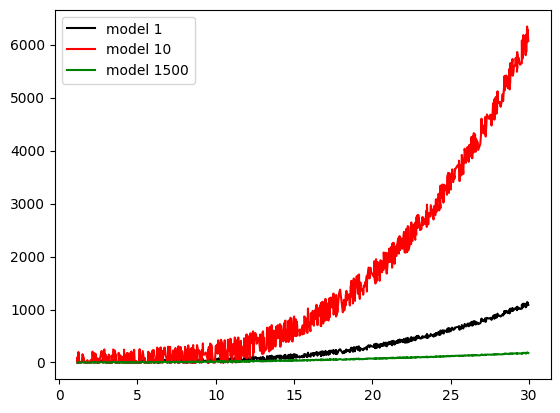

In [9]:
srt_idx = np.argsort(indata)
ax = plt.axes()
ax.plot(indata[srt_idx], obsdata[srt_idx,0], 'k-', label='model 1')
ax.plot(indata[srt_idx], obsdata[srt_idx,9], 'r-', label='model 10')
ax.plot(indata[srt_idx], obsdata[srt_idx,1500], 'g-', label='model 1500')
ax.legend()

In [10]:
print(obsdata.shape)

(1000, 2000)


In [42]:
class MscuaSetupSA:
    # Define parameters here (before __init__) as variables
    # These are the parameters specific to your model and will need to be defined for each MscuaSetup class
    coef = spotpy.parameter.Uniform(low=0.009, high=0.15)
    exp = spotpy.parameter.Uniform(low=1.0, high=4.0)

    def __init__(self, objective_funcs, dbase: Optional[Union[str, Path, MultiDimDb]] = None):
        # define the multidimensional parameter space here
        # use identical names as you did above for your spotpy parameter definitions (the variable assignment name)
        # if using spatial data this would be the number of features you are calibrating
        self.parameter_dimension = {
            'coef': 2000,
            'exp': 2000,
        }
        # This customizes the dimension name that is carried through the database, here I used "curve" but this could be
        #   feature, model, field, HRU, whatever descriptive name the parameter is attached to.
        self.param_dim_names = {
            'coef': 'curve',
            'exp': 'curve',
        }
        # These attributes may be specific to your model setup, in-data might be a file path to an input file for instance
        #   and observation data may come from another file.
        self.indata = mdindata
        self.observation_data = obsdata
        # This can be left alone, this just ensures multiple objective functions can be passed during setup or treated as an iterable
        if isinstance(objective_funcs, list):
            self.objfuncs = objective_funcs
        else:
            self.objfuncs = [objective_funcs]
    # This method must be in the setup class, it is called during calibration to run the model, its only input should be a set
    #   of parameters. This could be an ordered list, tuple, however you want to set it up. I used a dictionary because it maintains
    #   reference to the parameter name and then you don't have to worry about order. This returns model output...for more complex model
    #   setups you might have a lot of code here to ingest parameters, change the parameters in the model files, and process the model outputs
    #   so that they can be returned as a Python object.
    def simulation(self, paramdict):
        modout = exp_model(self.indata, **paramdict)

        return modout
        
    # This is a required method. It can be more complex if needed but it doesn't really need any arguments, it just needs to
    #   return the observation data to compare with the modeled data.
    def evaluation(self):
        return self.observation_data

    # This must return a dictionary where the keys are the objective function names
    # This is set up to calculate an entire 3D array of simulation results - dimensions (model reps, model vals, # models)
    # This can be customized to whatever you need for your model, the multidimensional objective functions included above can be manipulated by
    #   passing the axis argument (calculated objective function on a particular axis or for the entire array) they also include an option to return a
    #   dictionary with the objective function name (default is to just return numpy array), this dictionary is necessary for tracking results
    #   through the algorithm for each objective function.
    def objectivefunction(self, observation, simulation):
        results = {}
        for o in tqdm.tqdm(self.objfuncs, desc="Calculating Objective Functions", leave=False):
            r = o(observation=observation, simulation=simulation, return_dict=True)
            results.update(r)
        
        return results

In [43]:
SAsetup = MscuaSetupSA([nrmse_md, rmse_md, pbias_md, nse_md])

In [44]:
sa = SensitivityAnalysis(SAsetup)

In [45]:
sa.sample()

Sampling 10 repetitions of the coef parameter...


Sampling 10 repetitions of the exp parameter...


In [46]:
sa.results

<xarray.Dataset>
Dimensions:              (parameters: 2, repetitions: 10, curve: 2000,
                          objective_functions: 4)
Coordinates:
  * parameters           (parameters) <U4 'coef' 'exp'
  * repetitions          (repetitions) int32 1 2 3 4 5 6 7 8 9 10
  * curve                (curve) int32 1 2 3 4 5 6 ... 1996 1997 1998 1999 2000
  * objective_functions  (objective_functions) <U5 'nrmse' 'rmse' 'pbias' 'nse'
Data variables:
    samples              (parameters, repetitions, curve) float64 dask.array<chunksize=(2, 10, 2000), meta=np.ndarray>
    nrmse                (parameters, repetitions, curve) float64 dask.array<chunksize=(2, 10, 2000), meta=np.ndarray>
    rmse                 (parameters, repetitions, curve) float64 dask.array<chunksize=(2, 10, 2000), meta=np.ndarray>
    pbias                (parameters, repetitions, curve) float64 dask.array<chunksize=(2, 10, 2000), meta=np.ndarray>
    nse                  (parameters, repetitions, curve) float64 dask.array<chunksize=(2, 10, 2000), meta=np.ndarray>
    sensitivity_index    (objective_functions, parameters, curve) float64 dask.array<chunksize=(4, 2, 2000), meta=np.ndarray>

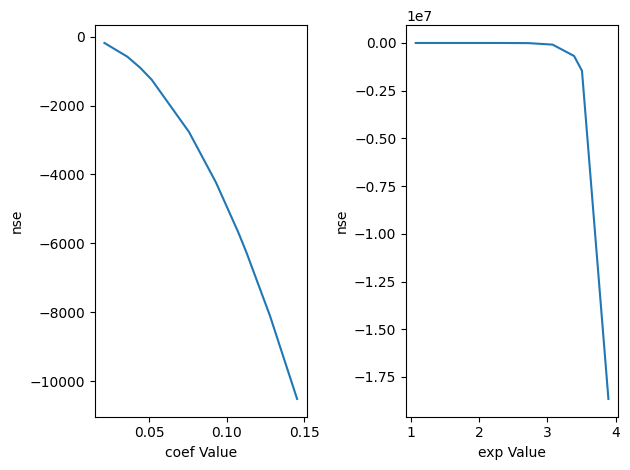

In [47]:
sa.plot_obj_func('nse', 500)

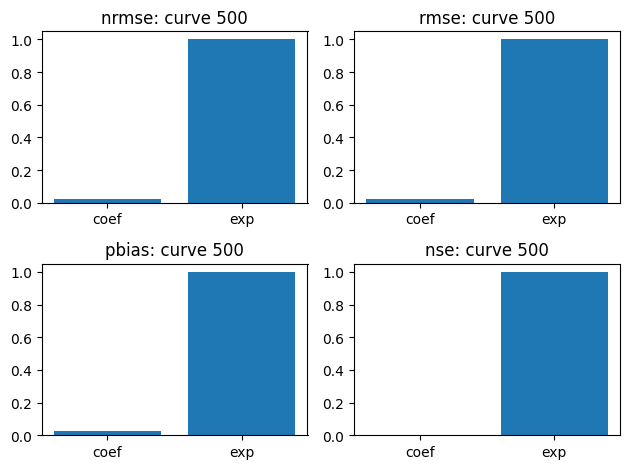

In [48]:
sa.plot_sensitivity_index(500)

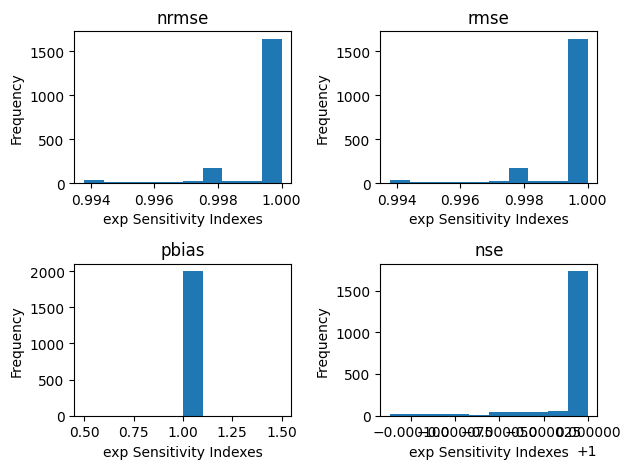

In [50]:
sa.plot_sensitivity_distribution('exp')

Now we define the Setup Class for the calibration algorithm. This is the key ingredient for the MSCUA multidimensional algorithm. The Setup Class is the custom class that links your model to the database, and the relevant algorithm methods. The structure can remain the same but most things will need to be tailored to your model.

In [18]:
class MscuaSetupIter1:
    # Define parameters here (before __init__) as variables
    # These are the parameters specific to your model and will need to be defined for each MscuaSetup class
    coef = spotpy.parameter.Uniform(low=0.009, high=0.15)
    exp = spotpy.parameter.Uniform(low=1.0, high=4.0)

    def __init__(self, objective_funcs, dbase: Optional[Union[str, Path, MultiDimDb]] = None):
        # define the multidimensional parameter space here
        # use identical names as you did above for your spotpy parameter definitions (the variable assignment name)
        # if using spatial data this would be the number of features you are calibrating
        self.parameter_dimension = {
            'coef': 2000,
            'exp': 2000,
        }
        # This customizes the dimension name that is carried through the database, here I used "curve" but this could be
        #   feature, model, field, HRU, whatever descriptive name the parameter is attached to.
        self.param_dim_names = {
            'coef': 'curve',
            'exp': 'curve',
        }
        # These attributes may be specific to your model setup, in-data might be a file path to an input file for instance
        #   and observation data may come from another file.
        self.indata = mdindata
        self.observation_data = obsdata
        # This can be left alone, this just ensures multiple objective functions can be passed during setup or treated as an iterable
        if isinstance(objective_funcs, list):
            self.objfuncs = objective_funcs
        else:
            self.objfuncs = [objective_funcs]
    # This method must be in the setup class, it is called during calibration to run the model, its only input should be a set
    #   of parameters. This could be an ordered list, tuple, however you want to set it up. I used a dictionary because it maintains
    #   reference to the parameter name and then you don't have to worry about order. This returns model output...for more complex model
    #   setups you might have a lot of code here to ingest parameters, change the parameters in the model files, and process the model outputs
    #   so that they can be returned as a Python object.
    def simulation(self, paramdict):
        modout = exp_model(self.indata, **paramdict)

        return modout
        
    # This is a required method. It can be more complex if needed but it doesn't really need any arguments, it just needs to
    #   return the observation data to compare with the modeled data.
    def evaluation(self):
        return self.observation_data

    # This must return a dictionary where the keys are the objective function names
    # This is set up to calculate an entire 3D array of simulation results - dimensions (model reps, model vals, # models)
    # This can be customized to whatever you need for your model, the multidimensional objective functions included above can be manipulated by
    #   passing the axis argument (calculated objective function on a particular axis or for the entire array) they also include an option to return a
    #   dictionary with the objective function name (default is to just return numpy array), this dictionary is necessary for tracking results
    #   through the algorithm for each objective function.
    def objectivefunction(self, observation, simulation):
        results = {}
        for o in tqdm.tqdm(self.objfuncs, desc="Calculating Objective Functions", leave=False):
            r = o(observation=observation, simulation=simulation, return_dict=True, axis=1)
            results.update(r)
        
        return results

And initialize the setup class with the normalized root mean square error objective function.

In [19]:
setup = MscuaSetupIter1(nrmse_md)

In [20]:
plist = build_parameter_list(setup, setup.parameter_dimension, setup.param_dim_names)

In [22]:
[p() for p in plist]

[0.07738878215711834, 1.7296042750826177]

Now we will initialize a new MsCua Sampler.

In [13]:
sampler = MsCua(setup)

In Memory database initialized...


Now we will run the ```.sample()``` method which will sample the parameters space based on the reps argument, run the model, calculate objective function values, and filter parameter distributions based on the provided thresholds. The ```.sample()``` method will return index arrays if certain threshold requirements are not met. While most of the work writes directly to the database, I assign the output "results" variable to capture any failed iterations. This can be used later to filter those problem indexes out.

In [14]:
results = sampler.sample(1000, {'nrmse': 0.6}, use_distribution=False)

Sampling 1000 repetitions of the coef parameter...


Sampling 1000 repetitions of the exp parameter...


Running model for 1000 repititions in database...


Evaluating Objective Function Values...


Max number of refined parameter sets: 120
Min number of refined parameter sets: 6
Calculating the 95PPU...
Calculating p- and r-factor metrics...
Max p-factor = 0.99
Min p-factor = 0.542
Min r-factor = 0.48445819879291724
Max r-factor = 1.7382816104084091
23 models had fewer than the minimum allowable refined parameter sets: 25. Either increase the number of samples or exclude these models.
Returning array of failed model indexes.
All models had p-factor greater than 0.35


As I said, all the algorithm operations are saved to the database, which we now convert to an xarray Dataset for easier indexing and handling.

In [15]:
cal_ds = sampler.database.to_xarray()

In [16]:
cal_ds

<xarray.Dataset>
Dimensions:                       (repetition: 1000, curve: 2000,
                                   observation: 1000, objective_functions: 1,
                                   parameters: 2, scalar: 1)
Coordinates:
  * repetition                    (repetition) int32 1 2 3 4 ... 998 999 1000
  * curve                         (curve) int32 1 2 3 4 ... 1997 1998 1999 2000
  * observation                   (observation) int32 1 2 3 4 ... 998 999 1000
  * objective_functions           (objective_functions) <U5 'nrmse'
  * parameters                    (parameters) <U4 'coef' 'exp'
Dimensions without coordinates: scalar
Data variables: (12/16)
    coef_samples                  (repetition, curve) float64 0.1148 ... 0.09831
    exp_samples                   (repetition, curve) float64 2.47 ... 1.224
    coef_refined                  (repetition, curve) float64 nan nan ... nan
    exp_refined                   (repetition, curve) float64 nan nan ... nan
    nrmse                         (repetition, curve) float64 1.441 ... 1.422
    best_simulation_nrmse         (observation, curve) float64 2.117e+03 ... ...
    ...                            ...
    rfactor                       (curve) float64 0.6078 0.6412 ... 1.115 0.7349
    95PPU_lower                   (observation, curve) float64 1.338e+03 ... ...
    95PPU_upper                   (observation, curve) float64 2.736e+03 ... ...
    pfactor_threshold             (scalar) float64 0.35
    min_refined_params_threshold  (scalar) int32 25
    obj_func_thresholds           (objective_functions) float64 0.6

The ```MsCuaAnalyzer``` class provides easy ways to plot and run diagnostics on the current MsCua iteration. You can initialize this class with a database or an xarray Dataset created from a database.

In [17]:
ana = MsCuaAnalyzer(cal_ds)

Let's plot all the diagnostics from this iteration.

p-factor determines the percent overlap between the 95% percentile prediction uncertainty (95PPU) and the observed data. p-factor ranges from 0 - 1 with 1 meaning that all obesrved data are contained within the 95PPU. This has a default threshold of 0.35. You can see in the distribution that nearly all of the 2000 models calibrated were above the threshold.

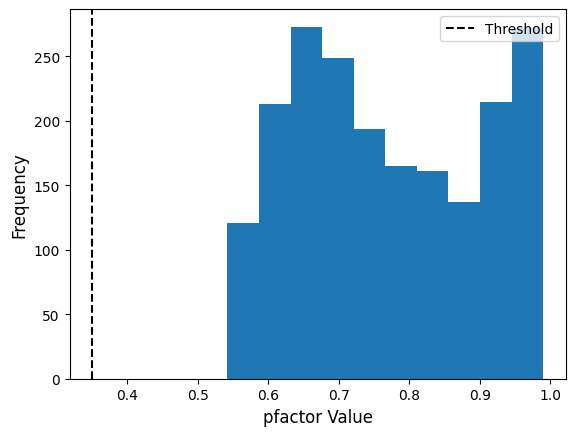

In [18]:
ana.plot_pfactor(threshold=True)

The r-factor compares the spread of the measured data with the spread of the 95PPU. This is an additional diagnostic to the p-factor which can be misleading if your 95PPU is REALLY large, it will obviously contain all the observed data points. r-factor can range from 0 to infinity and a lower value is better (low r-factor with high p-factor is ideal).

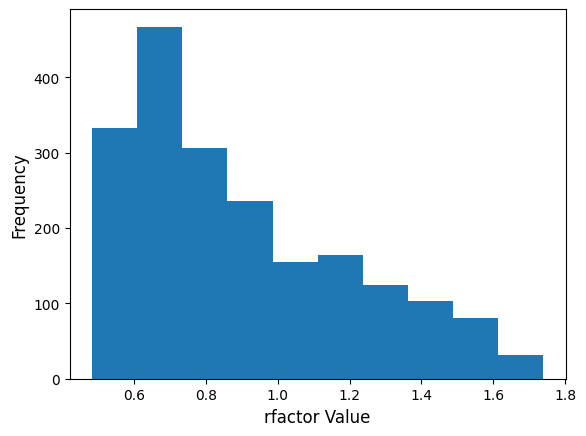

In [19]:
ana.plot_rfactor()

We can also plot the refined distribution of each of the calibrated parameters.

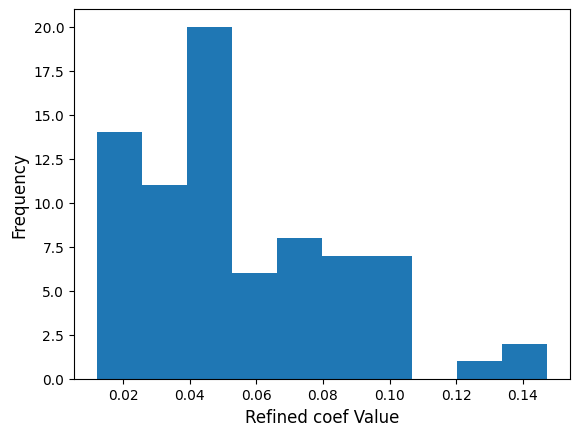

In [20]:
ana.plot_refined_parameters(param='coef', indx=1500)

Or, compare the pre- and post- calibration parameter distributions. Obviously in this case our pre-distribution was just a Uniform distribution for a given range.

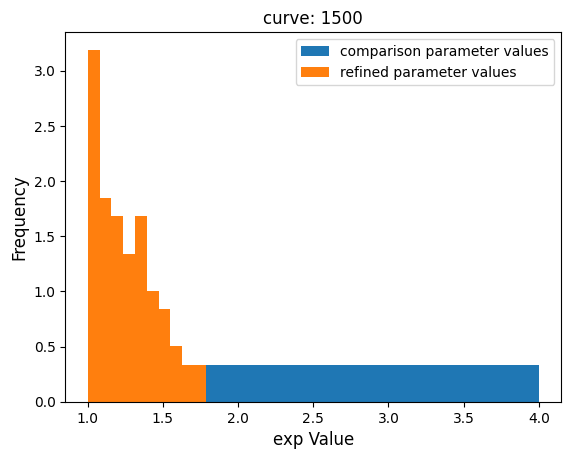

In [21]:
ana.compare_parameter_distributions('exp', comp_dstb=cal_ds.exp_samples.values[:,1500], indx=1500, density=True)

We can use the analyzer class to also look at the distribution of objective function values for each model over the number of repititions.

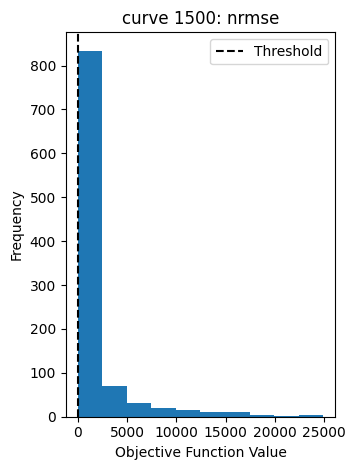

In [22]:
ana.plot_objective_functions(1500, threshold=True)

Plot the 95PPU with observation data and the best simulation result for the current interation.

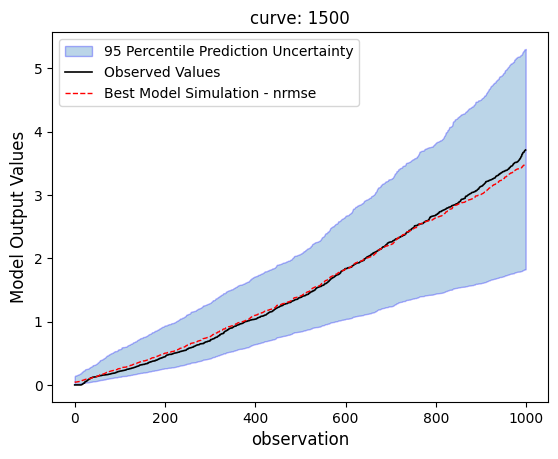

In [23]:
nobsdat = np.where(obsdata < 0, 0, obsdata)
ana.plot_ppu(1500, best_sim=True, obs_data=nobsdat, sort=True)

We can plot the values (for each model) of the best objective function result that defines the best simulation for the current iteration.

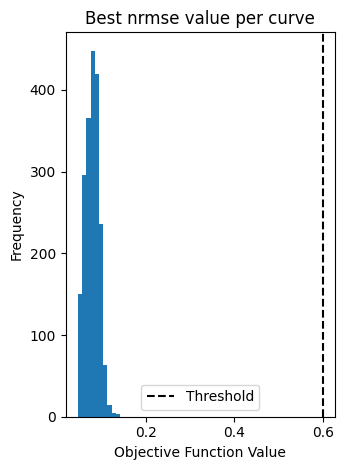

In [24]:
ana.plot_best_objfuncs(threshold=True)

We can also plot the number of refined parameter sets (the parameter sets for each model that were not filtered out by the objective function thresholds).

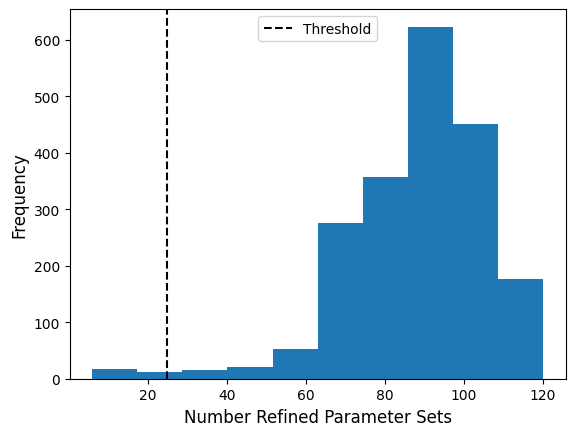

In [25]:
ana.plot_number_refined_params(threshold=True)

Next we can observe how the parameter distributions were altered during the current iteration.

First, we'll select only the successful models.

In [26]:
results

array([  21,   71,   97,  101,  452,  498,  518,  588,  645,  888,  999,
       1473, 1562, 1612, 1681, 1692, 1734, 1780, 1866, 1873, 1882, 1890,
       1964], dtype=int64)

In [27]:
failed = results

In [28]:
crves = np.arange(2000)
success = np.delete(crves, failed)

Now we loop through each successful model and use the analyzer class method ```.calc_param_distribution_change()``` which uses the Wasserstein Distance to measure the difference between the pre- and post- iteration parameter distributions.

In [29]:
exp_chng = []
coef_chng = []
for i in success:
    exp_dist = ana.calc_param_distribution_change('exp', comp_dstb=cal_ds.exp_samples.values[:,i], indx=i)
    coef_dist = ana.calc_param_distribution_change('coef', comp_dstb=cal_ds.coef_samples.values[:,i], indx=i)
    exp_chng.append(exp_dist)
    coef_chng.append(coef_dist)
exp_wd = np.array(exp_chng)
coef_wd = np.array(coef_chng)

The Wasserstein distance measures a relative amount of change that would need to occur to transform one distribution into the other. A value of 0.0 would mean the two ditributions are identical whereas a larger value means the two distributions are more different. Plotting the results for all the successful models, you see that the coef parameter did not change as much before and after this iteration (which is because mathematically it is less sensitive). The exp parameter though showed much higher values for nearly every successful model.

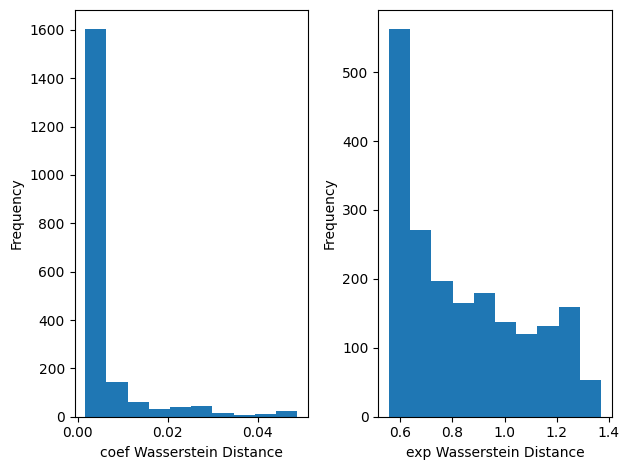

In [30]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(coef_wd)
axs[1].hist(exp_wd)
axs[0].set_xlabel("coef Wasserstein Distance")
axs[1].set_xlabel("exp Wasserstein Distance")
axs[0].set_ylabel("Frequency")
axs[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

Finally, the last test we can do, is to compare the calibrated parameters with the initial input parameters (since in this theoretical example we know what each model's parameter was). We could do this in a probabalistic way, comparing the distribution of the refined parameters, or the median of the refined distribution, or we could use the parameter value with the best objective function result...this is visualized in the following plot...

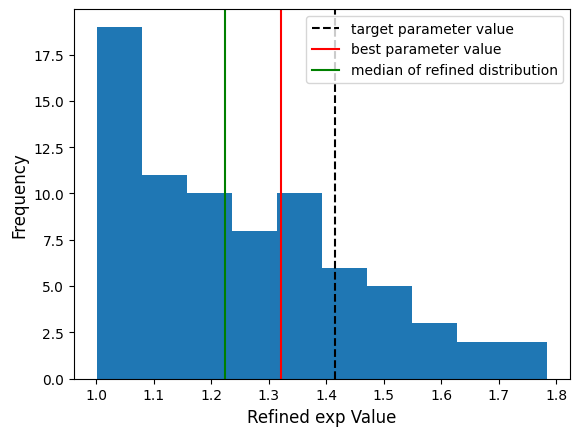

In [31]:
ax = plt.axes()
ax.axvline(target_exp[1500], color='black', ls='--', label='target parameter value')
ax.axvline(cal_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='exp', curve=1501).values, color='red', label='best parameter value')
ax.axvline(np.nanmedian(cal_ds.exp_refined.values[:,1500]), color='green', label='median of refined distribution')
ax.legend()
ana.plot_refined_parameters('exp', 1500, ax=ax)

You can see that the median and the best simulation are slightly different from the true parameter value but both are pretty close. Let's look at all the models together using the best simulation parameter sets...

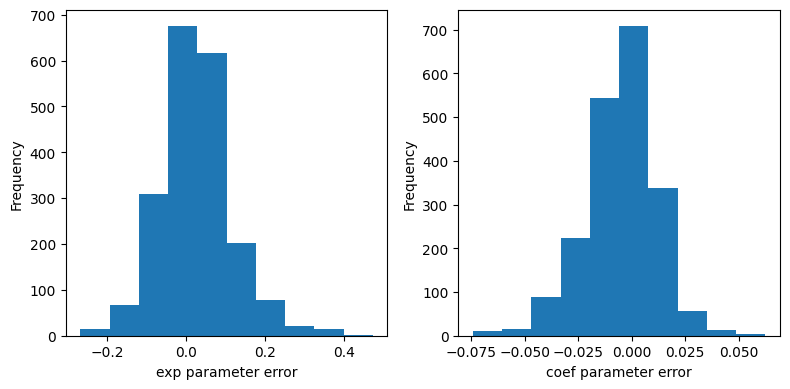

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(target_exp - cal_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='exp').values)
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("exp parameter error")
axs[1].hist(target_coef - cal_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='coef').values)
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("coef parameter error")
plt.tight_layout()
plt.show()

While most of the models had a parameter error close to 0.0, there is still a decent spread to these differences. This is because our objective function threshold was rather lax. Let's do another iteration with a much more stringent threshold...

But first, lets deal with our failed models, those that did not retain more than 25 refined parameter sets and/or had a p-factor < 0.35.

These probably failed because they were not well represented in the parameter samples...that can be fixed by increasing the sample size, or relaxing the objective function thresholds. A recommended approach for dealing with these would be to remove them completely and run a separate calibration for those problematic models. For this example, we will isolate those models and use our diagnostics to narrow our parameter search range and see if we can get them to meet the criteria, then we will add them back into our 1st iteration run before beginning iteration 2. If you have a model with significant runtime, you might choose to relax the objective functions instead of add more samples or do additional calibration schemes first. Just don't relax them TOO MUCH!!

Let's save our database as a netcdf first. Just to show that we can, and in case we want to recall any of that information later (remember, our Analyzer class can accept an xarray Dataset so we can revisit iteration 1 diagnostics whenever OR compare them to later iterations).

In [33]:
cal_ds.to_netcdf('Exp_Model_MSCUA_Iteration_1.nc')

Now we will isolate the relevant observation data for our failed models.

In [34]:
failed_obsdat = obsdata[:, failed]

Now, we can check our best parameter set from iteration 1 because even though the models failed our criteria, they still had 1000 different simulations and a "best" objective function result.

In [36]:
cal_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='coef').values[failed]

array([0.009848  , 0.02644555, 0.02644555, 0.02644555, 0.01145327,
       0.01634844, 0.01955936, 0.01408139, 0.02644555, 0.009848  ,
       0.02644555, 0.01408139, 0.02644555, 0.01634844, 0.01883467,
       0.0215018 , 0.01145327, 0.01408139, 0.02644555, 0.01408139,
       0.01883467, 0.02644555, 0.02644555])

We'll need a new setup class for the failed models. We just change a few things here from our previous setup:
1) adjust the parameter ranges
2) change our parameter dimensions to match the number of failed results
3) change our observation data to the failed observation data selection

That's all, everything else stays the same.

In [37]:
class MscuaSetupf1:
    # Define parameters here (before __init__) as variables
    coef = spotpy.parameter.Uniform(low=0.01, high=0.03)
    exp = spotpy.parameter.Uniform(low=1.0, high=1.4)

    def __init__(self, objective_funcs, dbase: Optional[Union[str, Path, MultiDimDb]] = None):
        self.parameter_dimension = {
            'coef': failed_obsdat.shape[1],
            'exp': failed_obsdat.shape[1],
        }
        self.param_dim_names = {
            'coef': 'curve',
            'exp': 'curve',
        }
        self.indata = mdindata
        self.observation_data = failed_obsdat
        
        if isinstance(objective_funcs, list):
            self.objfuncs = objective_funcs
        else:
            self.objfuncs = [objective_funcs]
   
    def simulation(self, paramdict):
        modout = exp_model(self.indata, **paramdict)

        return modout
        
    def evaluation(self):
        return self.observation_data

    def objectivefunction(self, observation, simulation):
        results = {}
        for o in tqdm.tqdm(self.objfuncs, desc="Calculating Objective Functions", leave=False):
            r = o(observation=observation, simulation=simulation, return_dict=True, axis=1)
            results.update(r)
        
        return results

Initialize the sampler and run ```.sample()``` just as before.

In [38]:
failed_setup = MscuaSetupf1(nrmse_md)
failed_sampler = MsCua(failed_setup)

In Memory database initialized...


In [39]:
failed_results = failed_sampler.sample(1000, {'nrmse': 0.6})

Sampling 1000 repetitions of the coef parameter...


Sampling 1000 repetitions of the exp parameter...


Running model for 1000 repititions in database...


Evaluating Objective Function Values...


Max number of refined parameter sets: 726
Min number of refined parameter sets: 281
Calculating the 95PPU...
Calculating p- and r-factor metrics...
Max p-factor = 0.98
Min p-factor = 0.928
Min r-factor = 1.3244804233072631
Max r-factor = 1.600624882776084
All models retained more refined parameter sets than the minimun: 25.
All models had p-factor greater than 0.35


SUCCESS, by narrowing the parameter search ranges for our problem models, they have all met the criteria. Let's add them back to our original iteration database (you could also do this by editing the xarray dataset/netcdf, either way).

In [40]:
for k,v in sampler.database.refined_parameters.items():
    v[:,failed] = failed_sampler.database.refined_parameters[k]

Now we can check this operation was successful and see that no model has fewer than 25 refined parameter sets.

In [41]:
nans = np.isnan(sampler.database.refined_parameters['coef'])
nz = np.count_nonzero(~nans, axis=0)
print(nz.min())

26


Alright, next iteration time. Again, we make a setup class. This time, it is identical to our iteration 1 setup class except now, we are going to use the spotpy List parameter class instead of Uniform. And, to initialize it we will pass it the refined parameters from our 1st iteration. What this does functionally is similar to what we just did with the failed models. We are now running the whole algorithm again but starting from a more representative parameter distribution.

In [42]:
class MscuaSetupIter2:
    # Define parameters here (before __init__) as variables
    coef = spotpy.parameter.List(sampler.database.refined_parameters['coef'])
    exp = spotpy.parameter.List(sampler.database.refined_parameters['exp'])

    def __init__(self, objective_funcs, dbase: Optional[Union[str, Path, MultiDimDb]] = None):
        self.parameter_dimension = {
            'coef': 2000,
            'exp': 2000,
        }
        self.param_dim_names = {
            'coef': 'curve',
            'exp': 'curve',
        }
        self.indata = mdindata
        self.observation_data = obsdata
        
        if isinstance(objective_funcs, list):
            self.objfuncs = objective_funcs
        else:
            self.objfuncs = [objective_funcs]
   
    def simulation(self, paramdict):
        modout = exp_model(self.indata, **paramdict)

        return modout
        
    def evaluation(self):
        return self.observation_data

    def objectivefunction(self, observation, simulation):
        results = {}
        for o in tqdm.tqdm(self.objfuncs, desc="Calculating Objective Functions", leave=False):
            r = o(observation=observation, simulation=simulation, return_dict=True, axis=1)
            results.update(r)
        
        return results

In [43]:
iter2_setup = MscuaSetupIter2(nrmse_md)
iter2_sampler = MsCua(iter2_setup)

In Memory database initialized...


When we go to sample this time, let's lower our threshold to 0.4 from 0.6. This should give us more refined parameters but also filter lots out again.

In [44]:
iter2_results = iter2_sampler.sample(1000, {'nrmse': 0.4}, use_distribution=False)

Sampling 1000 repetitions of the coef parameter...


Sampling 1000 repetitions of the exp parameter...


Running model for 1000 repititions in database...


Evaluating Objective Function Values...


Max number of refined parameter sets: 528
Min number of refined parameter sets: 149
Calculating the 95PPU...
Calculating p- and r-factor metrics...
Max p-factor = 0.986
Min p-factor = 0.508
Min r-factor = 0.34484421496018725
Max r-factor = 1.2278973907533175
All models retained more refined parameter sets than the minimun: 25.
All models had p-factor greater than 0.35


Alright, that was a success, didn't have any failed models. Let's set up the Analyzer and run the same/similar diagnostics.

In [45]:
iter2_ds = iter2_sampler.database.to_xarray()

In [46]:
iter2_ana = MsCuaAnalyzer(iter2_ds)

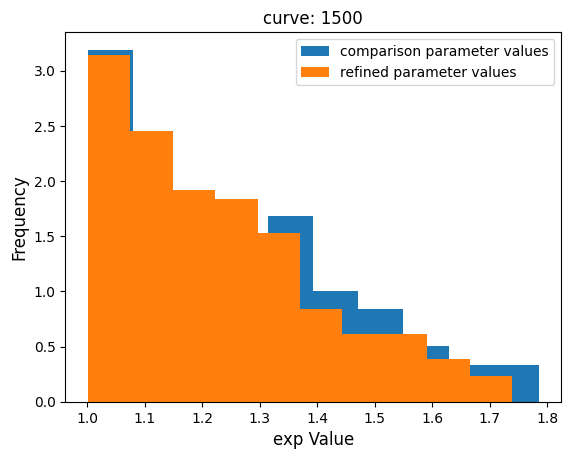

In [47]:
iter2_ana.compare_parameter_distributions('exp', comp_dstb=cal_ds.exp_refined.values[:,1500], indx=1500, density=True)

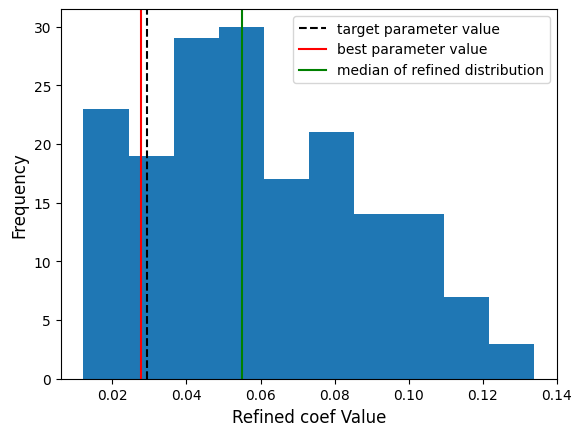

In [48]:
ax = plt.axes()
ax.axvline(target_coef[1500], color='black', ls='--', label='target parameter value')
ax.axvline(iter2_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='coef', curve=1501).values, color='red', label='best parameter value')
ax.axvline(np.nanmedian(iter2_ds.coef_refined.values[:,1500]), color='green', label='median of refined distribution')
ax.legend()
iter2_ana.plot_refined_parameters('coef', 1500, ax=ax)

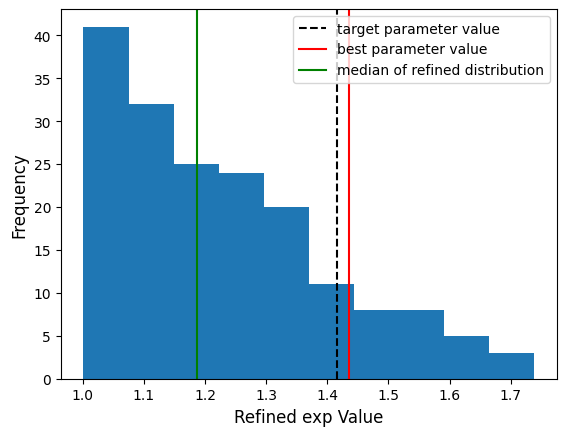

In [49]:
ax = plt.axes()
ax.axvline(target_exp[1500], color='black', ls='--', label='target parameter value')
ax.axvline(iter2_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='exp', curve=1501).values, color='red', label='best parameter value')
ax.axvline(np.nanmedian(iter2_ds.exp_refined.values[:,1500]), color='green', label='median of refined distribution')
ax.legend()
iter2_ana.plot_refined_parameters('exp', 1500, ax=ax)

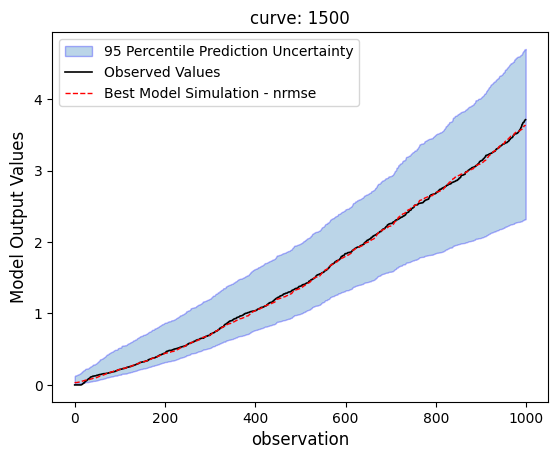

In [50]:
iter2_ana.plot_ppu(1500, best_sim=True, obs_data=nobsdat, sort=True)

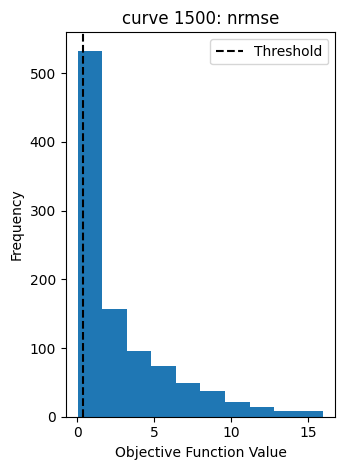

In [51]:
iter2_ana.plot_objective_functions(1500, threshold=True)

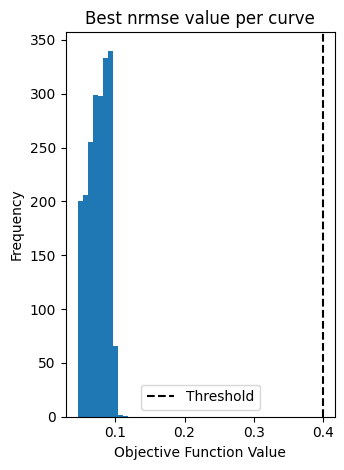

In [52]:
iter2_ana.plot_best_objfuncs(threshold=True)

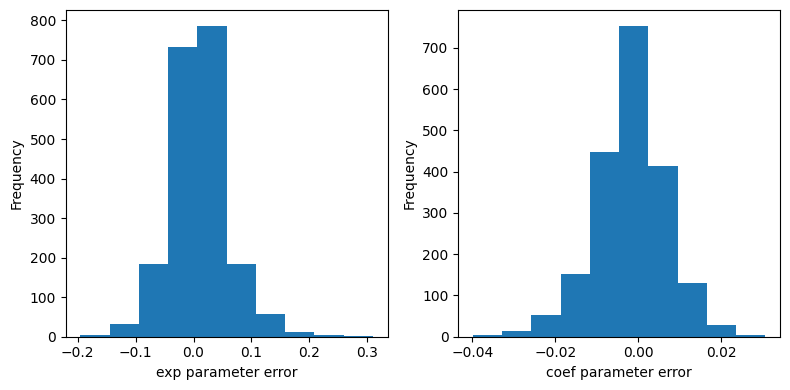

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(target_exp - iter2_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='exp').values)
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("exp parameter error")
axs[1].hist(target_coef - iter2_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='coef').values)
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("coef parameter error")
plt.tight_layout()
plt.show()

Great, it looks like all diagnostic metrics improved. Now, using a probablistic approach like MSCUA is different than an optimization algorthim because we have to use our best judgement and statistical tests to decide when it has "converged." These results look pretty good, we've significantly lowered our 95PPU bounds, better NRMSE distributions, and parameter error with the true values have much narrower distributions around 0.0. Given that I added noise into the theoretical example, we will never be able to truly replicate the original parameter values for ALL models (especially because noise was scaled based on parameter values). SO, you could argue that we are done, but let's see what happens with a 3rd iteration because...we can!!

In [54]:
class MscuaSetupIter3:
    # Define parameters here (before __init__) as variables
    coef = spotpy.parameter.List(iter2_ds.coef_refined.values)
    exp = spotpy.parameter.List(iter2_ds.exp_refined.values)

    def __init__(self, objective_funcs, dbase: Optional[Union[str, Path, MultiDimDb]] = None):
        self.parameter_dimension = {
            'coef': 2000,
            'exp': 2000,
        }
        self.param_dim_names = {
            'coef': 'curve',
            'exp': 'curve',
        }
        self.indata = mdindata
        self.observation_data = obsdata
        
        if isinstance(objective_funcs, list):
            self.objfuncs = objective_funcs
        else:
            self.objfuncs = [objective_funcs]
   
    def simulation(self, paramdict):
        modout = exp_model(self.indata, **paramdict)

        return modout
        
    def evaluation(self):
        return self.observation_data

    def objectivefunction(self, observation, simulation):
        results = {}
        for o in tqdm.tqdm(self.objfuncs, desc="Calculating Objective Functions", leave=False):
            r = o(observation=observation, simulation=simulation, return_dict=True, axis=1)
            results.update(r)
        
        return results

In [55]:
iter3_setup = MscuaSetupIter3(nrmse_md)
iter3_sampler = MsCua(iter3_setup)

In Memory database initialized...


For this 3rd one, let's get crazy and half the objective function threshold.

In [56]:
iter3_results = iter3_sampler.sample(1000, {'nrmse': 0.2}, use_distribution=False)

Sampling 1000 repetitions of the coef parameter...


Sampling 1000 repetitions of the exp parameter...


Running model for 1000 repititions in database...


Evaluating Objective Function Values...


Max number of refined parameter sets: 270
Min number of refined parameter sets: 32
Calculating the 95PPU...
Calculating p- and r-factor metrics...
Max p-factor = 0.982
Min p-factor = 0.408
Min r-factor = 0.16250649491170585
Max r-factor = 0.6866998048163613
All models retained more refined parameter sets than the minimun: 25.
All models had p-factor greater than 0.35


Again, successful run, let's look at the diagnostics...

In [57]:
iter3_ds = iter3_sampler.database.to_xarray()
iter3_ana = MsCuaAnalyzer(iter3_ds)

The 3rd iteration really did not alter our example parameter distributions all that much.

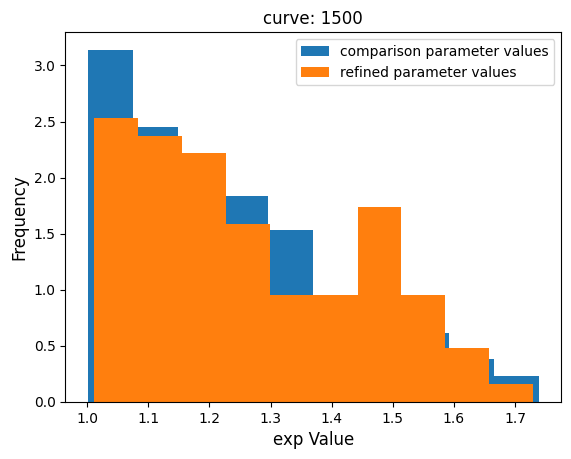

In [58]:
iter3_ana.compare_parameter_distributions('exp', comp_dstb=iter2_ds.exp_refined.values[:,1500], indx=1500, density=True)

Our refined parameter sets look to be mellowing out, and our best simulation is just bouncing around that range (suggests we are now within the "noise" envelope for our target parameter).

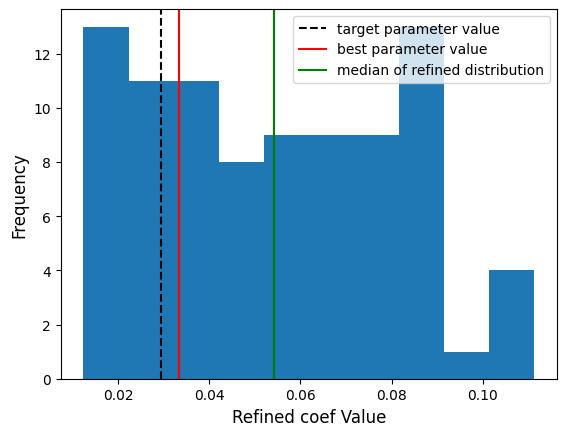

In [59]:
ax = plt.axes()
ax.axvline(target_coef[1500], color='black', ls='--', label='target parameter value')
ax.axvline(iter3_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='coef', curve=1501).values, color='red', label='best parameter value')
ax.axvline(np.nanmedian(iter3_ds.coef_refined.values[:,1500]), color='green', label='median of refined distribution')
ax.legend()
iter3_ana.plot_refined_parameters('coef', 1500, ax=ax)

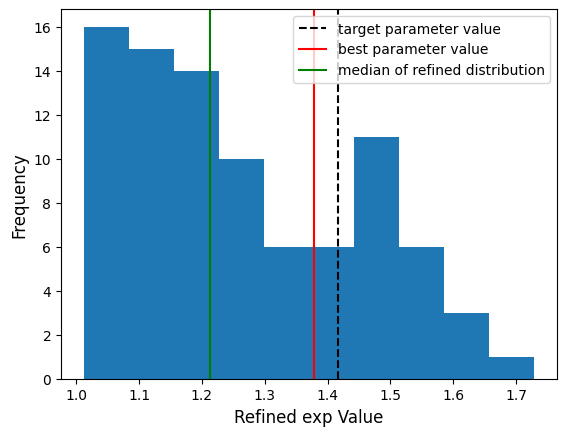

In [60]:
ax = plt.axes()
ax.axvline(target_exp[1500], color='black', ls='--', label='target parameter value')
ax.axvline(iter3_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='exp', curve=1501).values, color='red', label='best parameter value')
ax.axvline(np.nanmedian(iter3_ds.exp_refined.values[:,1500]), color='green', label='median of refined distribution')
ax.legend()
iter3_ana.plot_refined_parameters('exp', 1500, ax=ax)

One thing that did change, is our 95PPU bounds, they've gotten much tighter.

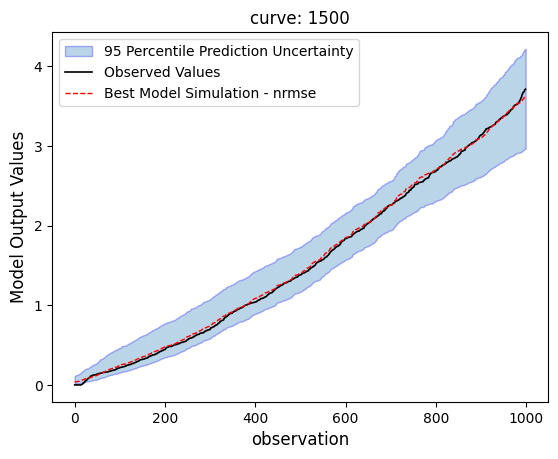

In [61]:
iter3_ana.plot_ppu(indx=1500, best_sim=True, obs_data=nobsdat, sort=True)

For our example model, the distribution of NRMSE values really didn't change.

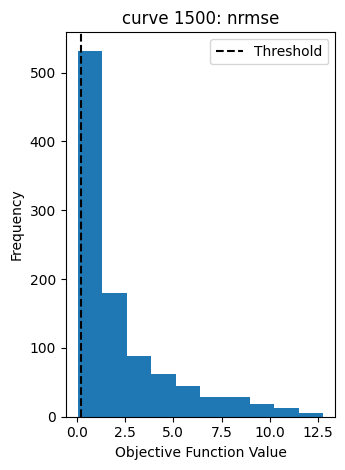

In [62]:
iter3_ana.plot_objective_functions(1500, threshold=True)

Similarily, our BEST objective function values across all models may have improved slightly, but not by much.

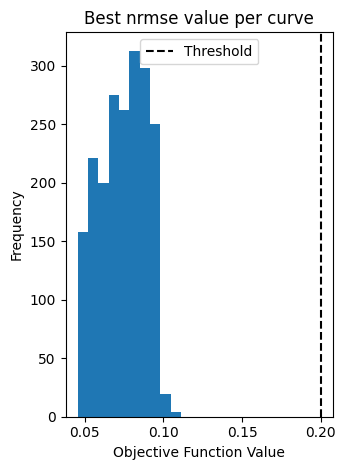

In [63]:
iter3_ana.plot_best_objfuncs(threshold=True)

Comparing to the actual parameter values, we see not much improvement either (again, we're solidly now bouncing around the "noise" envelope).

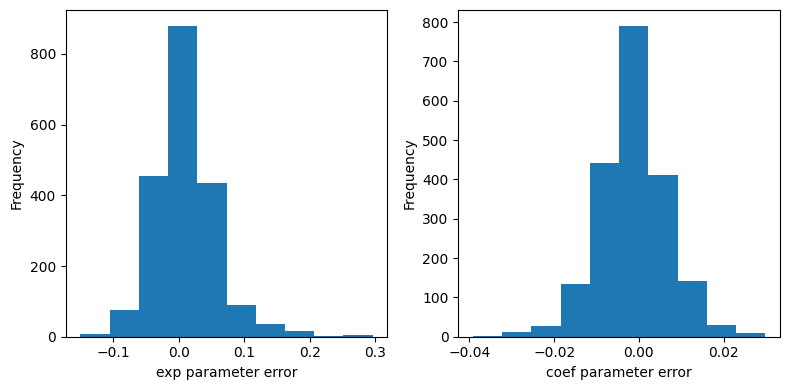

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(target_exp - iter3_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='exp').values)
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("exp parameter error")
axs[1].hist(target_coef - iter3_ds.best_parameter_set.sel(objective_functions='nrmse', parameters='coef').values)
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("coef parameter error")
plt.tight_layout()
plt.show()

One other check we can do again is the Wasserstein Distance. Remember we calculated this from iteration 1 to see how much the initial distributions changed.

In [65]:
exp_chng = []
coef_chng = []
for i in success:
    exp_dist = iter3_ana.calc_param_distribution_change('exp', comp_dstb=iter2_ds.exp_samples.values[:,i], indx=i)
    coef_dist = iter3_ana.calc_param_distribution_change('coef', comp_dstb=iter2_ds.coef_samples.values[:,i], indx=i)
    exp_chng.append(exp_dist)
    coef_chng.append(coef_dist)
exp_wd = np.array(exp_chng)
coef_wd = np.array(coef_chng)

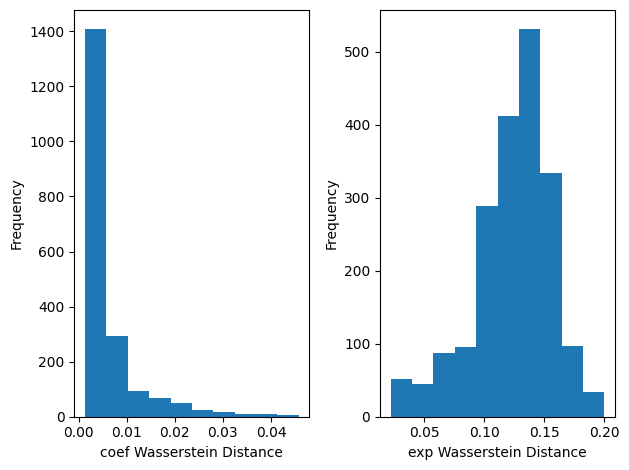

In [66]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(coef_wd)
axs[1].hist(exp_wd)
axs[0].set_xlabel("coef Wasserstein Distance")
axs[1].set_xlabel("exp Wasserstein Distance")
axs[0].set_ylabel("Frequency")
axs[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

This is a pretty telling check, we've pretty drastically changed these distributions meaning our parameter distributions are not really changing in the 3rd iteration. Remember we have max Wasserstein Distance for the "exp" parameter that were over 1.0, now they seem to have normalized around 0.13.

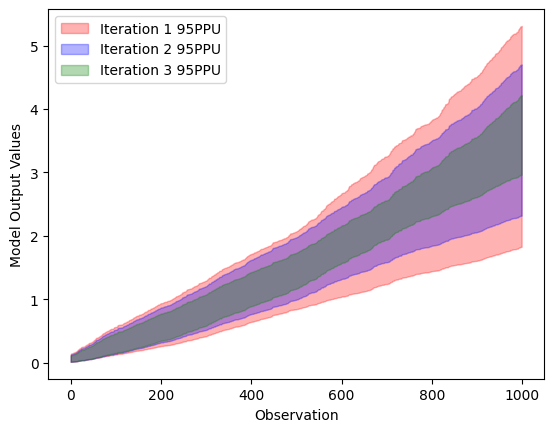

In [75]:
indx = 1500
i1_srt_idx = np.argsort(cal_ds["95PPU_lower"].values[:,indx])
i2_srt_idx = np.argsort(iter2_ds["95PPU_lower"].values[:,indx])
i3_srt_idx = np.argsort(iter3_ds["95PPU_lower"].values[:,indx])
ax = plt.axes()
ax.fill_between(np.arange(cal_ds["95PPU_lower"].values.shape[0]), 
                            cal_ds["95PPU_upper"].values[i1_srt_idx,indx], 
                            cal_ds["95PPU_lower"].values[i1_srt_idx,indx], 
                            label="Iteration 1 95PPU",
                            ec='red',
                            facecolor='red',
                            alpha=0.3)
ax.fill_between(np.arange(iter2_ds["95PPU_lower"].values.shape[0]), 
                            iter2_ds["95PPU_upper"].values[i2_srt_idx,indx], 
                            iter2_ds["95PPU_lower"].values[i2_srt_idx,indx], 
                            label="Iteration 2 95PPU",
                            ec='blue',
                            facecolor='blue',
                            alpha=0.3)
ax.fill_between(np.arange(iter3_ds["95PPU_lower"].values.shape[0]), 
                            iter3_ds["95PPU_upper"].values[i3_srt_idx,indx], 
                            iter3_ds["95PPU_lower"].values[i3_srt_idx,indx], 
                            label="Iteration 3 95PPU",
                            ec='green',
                            facecolor='green',
                            alpha=0.3)
ax.set_ylabel('Model Output Values')
ax.set_xlabel('Observation')
ax.legend()
plt.show()

So, the main benefit to adding a 3rd iteration was to reduce the calibrated model uncertainty. The "best" simulations did not really change much from iteration to iteration but the 95PPU got smaller and smaller, which we would expect as we make our objective function threshold more stringent. The above plot shows the decrease of the 95PPU with each iteration.